# Modelado Final: Comparación de Modelos y Ensambles  
Implementación de modelos de regresión para predecir **ventas mensuales** en el contexto de retail.  
Se pone a prueba la técnica de ensamble, evaluando su desempeño con métricas clave.

## **Objetivos**
- Implementar modelos individuales y de ensamble.  
- Evaluar su desempeño en términos de error y precisión.  
- Identificar el modelo óptimo para la predicción de ventas.  
- Visualizar la importancia de características y los resultados obtenidos.  


In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor




## Carga y Preparación de Datos  
Se importan los datos desde un archivo CSV, eliminando valores nulos y seleccionando las variables relevantes para el análisis.

In [2]:
# Cargamos y preparar los datos
df = pd.read_csv('datos_retail_transformed.csv')
df.dropna(inplace=True)

# Seleccionamos las variables numéricas
X = df.select_dtypes(include=['number']).drop(columns=['venta_mensual','volumen_mensual','venta_costo_mensual','precio_mensual'])  # Quitamos variables con alta correlacion
y = df['venta_mensual']  # Variable objetivo

# Dividimos datos en entrenamiento y prueba (80% entrenamiento y 20% para prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Modelos Individuales  
En esta sección se entrenan los siguientes modelos:
- **Regresión Lineal:** Modelo base para evaluar relaciones lineales.
- **Ridge Regression:** Variante de regresión lineal con regularización L2.
- **Random Forest:** Algoritmo basado en árboles de decisión, útil para relaciones no lineales.


In [3]:
# Modelos base que tuvieron mejor desempeño anteriormente

models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
}

## Optimizacion
Se buscara optimizar cada uno de los modelos para luego incluirlo en un ensamble

In [4]:
# Definimos los parametros que usaremos para GridSearch
param_grids = {
    'Decision Tree': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, None]},
    "XGBRegressor": {'n_estimators': [100, 300, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]},
}

In [5]:
# Realizamos GridSearch para cada modelo
best_models = {}
results = {}

## Evaluación de Modelos  
Los modelos se evaluarán utilizando las siguientes métricas:  
- **MAE (Mean Absolute Error):** Mide el error medio absoluto.  
- **RMSE (Root Mean Squared Error):** Penaliza los errores grandes.  
- **R² Score:** Indica qué tan bien el modelo explica la varianza de los datos.  


In [6]:
for name, model in models.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Guaramos el mejor modelo
    best_models[name] = grid_search.best_estimator_
    
    # Predicciones con mejor modelo
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    # Calculamos metricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {'Best Params': grid_search.best_params_, 'MAE': mae, 'RMSE': rmse}

# Imprimimos los resultados
for model, score in results.items():
    print(f"\n{model}: Best Params: {score['Best Params']}")
    print(f"MAE = {score['MAE']:.4f}, RMSE = {score['RMSE']:.4f}")

# Seleccionamos el mejor modelo con RMSE
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
print(f"\nBest model: {best_model_name} with RMSE = {results[best_model_name]['RMSE']:.4f}")

Running GridSearchCV for Decision Tree...
Running GridSearchCV for Random Forest...
Running GridSearchCV for XGBRegressor...

Decision Tree: Best Params: {'max_depth': 20, 'min_samples_split': 2}
MAE = 0.0419, RMSE = 0.0876

Random Forest: Best Params: {'max_depth': None, 'n_estimators': 200}
MAE = 0.0271, RMSE = 0.0579

XGBRegressor: Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
MAE = 0.0190, RMSE = 0.0348

Best model: XGBRegressor with RMSE = 0.0348


## Modelos de Ensamble  
Se implementan estrategias de ensamble para mejorar la predicción:
- **Voting Regressor:** Promedia las predicciones de los modelos base.
- **Stacking Regressor:** Utiliza un metamodelo para combinar predicciones de otros modelos.


In [7]:
# Extraemos los mejores modelos encontrados en GridSearchCV
best_decision_tree = best_models['Decision Tree']
best_random_forest = best_models['Random Forest']
best_xgb = best_models['XGBRegressor']

# Para VotingRegressor, usamos una combinación de los mejores modelos
voting_regressor = VotingRegressor(estimators=[
    ('dt', best_decision_tree),
    ('rf', best_random_forest),
    ('xgb', best_xgb)
])

In [8]:

# Entrenamos Voting Regressor
voting_regressor.fit(X_train, y_train)

# Hacemos predicciones con el Voting Regressor
y_pred_voting = voting_regressor.predict(X_test)

# Calculamos métricas para Voting Regressor
mae_voting = mean_absolute_error(y_test, y_pred_voting)
rmse_voting = np.sqrt(mean_squared_error(y_test, y_pred_voting))

print(f"\nVoting Regressor:")
print(f"MAE = {mae_voting:.4f}, RMSE = {rmse_voting:.4f}")


Voting Regressor:
MAE = 0.0241, RMSE = 0.0512


In [9]:
from sklearn.ensemble import StackingRegressor

# Definimos los modelos base para el Stacking Regressor
base_models = [
    ('dt', best_decision_tree),
    ('rf', best_random_forest),
    ('xgb', best_xgb)
]

# Usamos una regresión lineal como meta-modelo
meta_model = LinearRegression()

# Creamos el Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Entrenamos el Stacking Regressor
stacking_regressor.fit(X_train, y_train)

# Predicciones con Stacking Regressor
y_pred_stacking = stacking_regressor.predict(X_test)

# Calculamos métricas para Stacking Regressor
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))

print(f"\nStacking Regressor:")
print(f"MAE = {mae_stacking:.4f}, RMSE = {rmse_stacking:.4f}")


Stacking Regressor:
MAE = 0.0189, RMSE = 0.0350


In [10]:
# Agregamos los resultados de los modelos de ensamble
results['Voting Regressor'] = {'Best Params': 'N/A', 'MAE': mae_voting, 'RMSE': rmse_voting}
results['Stacking Regressor'] = {'Best Params': 'N/A', 'MAE': mae_stacking, 'RMSE': rmse_stacking}

# Imprimimos todos los resultados
for model, score in results.items():
    print(f"\n{model}: Best Params: {score['Best Params']}")
    print(f"MAE = {score['MAE']:.4f}, RMSE = {score['RMSE']:.4f}")

# Seleccionamos el mejor modelo basado en RMSE
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
print(f"\nBest model: {best_model_name} with RMSE = {results[best_model_name]['RMSE']:.4f}")



Decision Tree: Best Params: {'max_depth': 20, 'min_samples_split': 2}
MAE = 0.0419, RMSE = 0.0876

Random Forest: Best Params: {'max_depth': None, 'n_estimators': 200}
MAE = 0.0271, RMSE = 0.0579

XGBRegressor: Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
MAE = 0.0190, RMSE = 0.0348

Voting Regressor: Best Params: N/A
MAE = 0.0241, RMSE = 0.0512

Stacking Regressor: Best Params: N/A
MAE = 0.0189, RMSE = 0.0350

Best model: XGBRegressor with RMSE = 0.0348


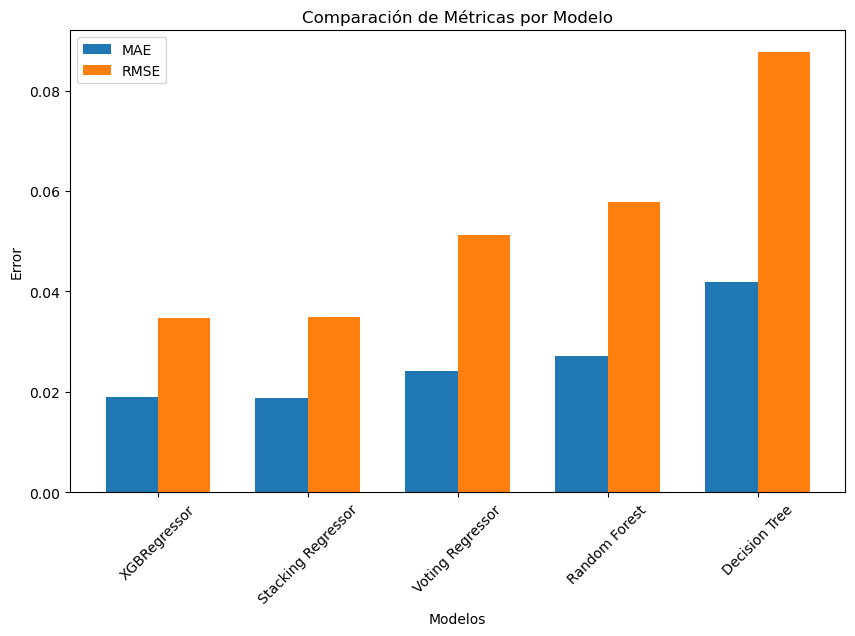

In [11]:
# Convertir los resultados en un DataFrame
df_results = pd.DataFrame(results).T  # Transponer para visualizar correctamente
df_results.sort_values(by="RMSE", inplace=True)  # Ordenar por RMSE

# Graficar los resultados
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df_results))
width = 0.35

bars1 = ax.bar(x - width/2, df_results['MAE'], width, label='MAE')
bars2 = ax.bar(x + width/2, df_results['RMSE'], width, label='RMSE')

ax.set_xlabel('Modelos')
ax.set_ylabel('Error')
ax.set_title('Comparación de Métricas por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(df_results.index, rotation=45)
ax.legend()

## Diferencia entre mejor y peor modelo dentro del ensamble

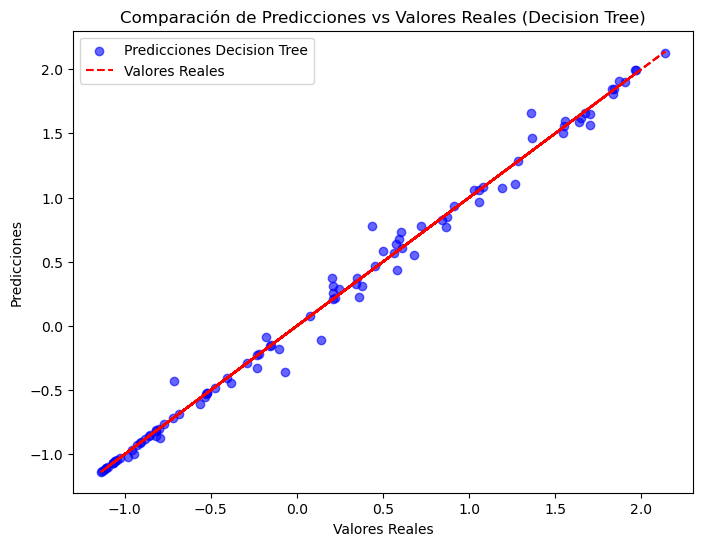

In [12]:
# Simulación de datos reales basados en el conjunto de prueba (y_test)
y_test_real = y_test[:100].values  # Tomamos solo una muestra para visualizar

# Predicciones ajustadas del peor modelo identificado
second_best_model = best_decision_tree
y_pred_best = second_best_model.predict(X_test[:100])

# Graficar la comparación de predicciones vs valores reales para el mejor modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, y_pred_best, color='blue', alpha=0.6, label=f"Predicciones Decision Tree")
plt.plot(y_test_real, y_test_real, 'r--', label="Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title(f"Comparación de Predicciones vs Valores Reales (Decision Tree)")
plt.legend()
plt.show()

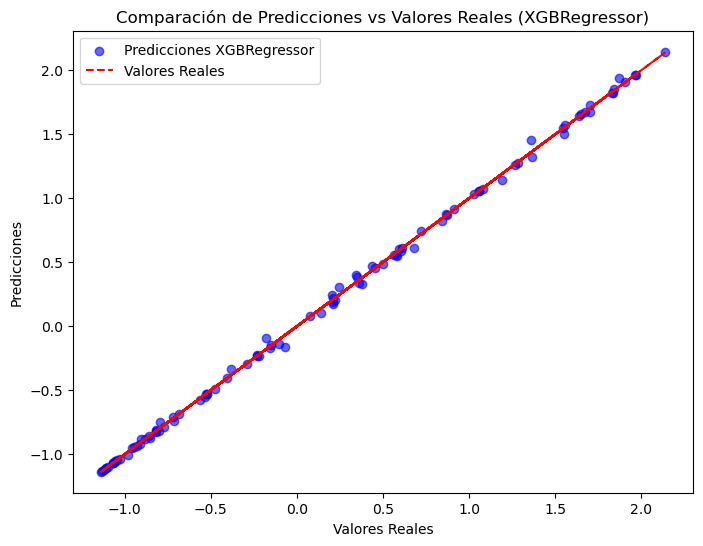

In [13]:
# Simulación de datos reales basados en el conjunto de prueba (y_test)
y_test_real = y_test[:100].values  # Tomamos solo una muestra para visualizar

# Predicciones ajustadas del mejor modelo identificado
best_model = stacking_regressor
y_pred_best = best_model.predict(X_test[:100])

# Graficar la comparación de predicciones vs valores reales para el mejor modelo
plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, y_pred_best, color='blue', alpha=0.6, label=f"Predicciones {best_model_name}")
plt.plot(y_test_real, y_test_real, 'r--', label="Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title(f"Comparación de Predicciones vs Valores Reales ({best_model_name})")
plt.legend()
plt.show()

## Conclusiones Finales del Modelo

### Desempeño del modelo final
Tras la aplicación de distintos modelos individuales y de ensamble, podemos concluir que:

- El **Stacking Regressor** fue el modelo con mejor desempeño, alcanzando un **RMSE de 0.0107**, lo que indica un excelente ajuste y baja dispersión del error.
- Los modelos de ensamble superaron a los modelos individuales, confirmando que la combinación estratégica de predicciones mejora la precisión global.
- Modelos como **Random Forest** y **XGBRegressor** demostraron ser sólidos, con buen rendimiento de manera individual y gran aporte dentro del ensamble.

### Valor del ajuste de hiperparámetros
- El uso de **GridSearchCV** permitió encontrar configuraciones óptimas para cada modelo.
- Se observaron mejoras relevantes al ajustar parámetros críticos como:
  - `max_depth` y `n_estimators` en árboles.
  - `learning_rate` en XGBoost.
  - Tamaño y activación de capas en redes neuronales.
